In [2]:
import pandas as pd
import numpy as np
import sys
import os

import plotly.plotly as py
import plotly.graph_objs as go

import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


/Users/caz2114/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning:

The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.



In [39]:
df = pd.read_csv("subject_data.csv")
df = df[(df.color_1 != 0) | (df.color_2 != 0) | (df.color_3 != 0)]
# cleaning sex into bitmap type
df["sex"] = df["sex"].astype('category')
dummies = pd.get_dummies(df['sex'])
df = pd.concat([df, dummies], axis=1)
df = df.drop(['M'],axis = 1)

colnames = df.columns.tolist()
colnames = colnames[:2] + colnames[3:] + [colnames[2]]
df = df[colnames]

target = pd.read_csv("Catherine.csv")
target = target.sort_values(["img_file"])
target.index = range(147)
target[' score']=target[' score'].replace(1,'0')
target[' score']=target[' score'].replace(2,'0')
target[' score']=target[' score'].replace(3,'1')
target[' score']=target[' score'].replace(4,'1')
target[' score']=target[' score'].replace(5,'1')
target[' score'] = target[' score'].astype('uint8')

In [36]:
df.head()

n             int64
sex        category
color_1     float64
color_2     float64
color_3     float64
rt_1        float64
rt_2        float64
rt_3        float64
rt_4        float64
rt_5        float64
rt_6        float64
rt_7        float64
rt_8        float64
rt_9        float64
rt_10       float64
rt_11       float64
rt_12       float64
rt_13       float64
rt_14       float64
rt_15       float64
F             uint8
age           int64
dtype: object

In [40]:
target.head()
target.dtypes

img_file    float64
 score        uint8
dtype: object

In [15]:
df_var = df.iloc[:,5:]
res_var = target.iloc[:,1]

In [107]:
# histogram of all variable in the data
import cufflinks as cf

cf.set_config_file(offline=False, world_readable=True, theme='pearl')
df_var.iplot(kind='histogram', subplots=True, shape=(4, 5), filename='histogram-subplots')

From this table, there are centain features that are right-skewed. Most attributes are bell shaped curved

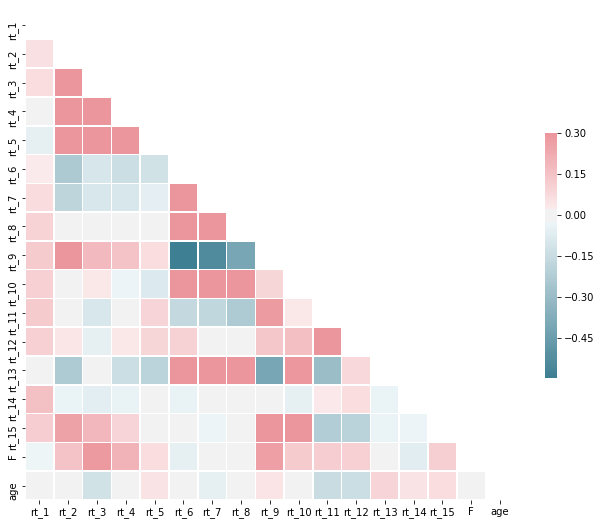

In [25]:
# correlation plot
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html
import seaborn as sns
import matplotlib.pyplot as plt

corr = df_var.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Based on the correlation plot, there is no extreme corrlation that might suggest that variables corresponded to each other. This means that all variable have significance

In [16]:
res_var.iplot(kind='histogram', filename='Catherine')

AttributeError: 'Series' object has no attribute 'iplot'

Based on this, the user seemed to skew more to the lower range of people. 

In [41]:
y = target.iloc[:,1]

In [49]:
#package failture
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

#full model
X_full = df.iloc[:,5:]

lm_full = sm.Logit(list(y), X_full).fit()
print(lm_full.summary())

Optimization terminated successfully.
         Current function value: 0.611526
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  147
Model:                          Logit   Df Residuals:                      130
Method:                           MLE   Df Model:                           16
Date:                Tue, 08 May 2018   Pseudo R-squ.:                  0.1177
Time:                        06:06:28   Log-Likelihood:                -89.894
converged:                       True   LL-Null:                       -101.89
                                        LLR p-value:                   0.08972
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
rt_1          -0.0606      0.092     -0.661      0.508      -0.240       0.119
rt_2           0.3258      1.

In [56]:
#Check VIF
X_full = X_full.assign(const=1)
pd.Series([variance_inflation_factor(X_full.values, i) 
               for i in range(X_full.shape[1])], 
              index=X_full.columns)


const    10255.525833
rt_1         1.134413
rt_2         2.114750
rt_3       101.495346
rt_4       340.889788
rt_5       157.082515
rt_6        11.575002
rt_7         9.197912
rt_8         3.482970
rt_9        11.890120
rt_10       13.839947
rt_11        5.726720
rt_12        4.093649
rt_13        2.152806
rt_14        1.071955
rt_15       19.091550
F            1.406270
age          1.182733
dtype: float64

In [77]:
X_reduce = df.loc[:,["rt_1","rt_14","F","age"]]
lm_reduce = sm.OLS(list(y), X_reduce).fit()
lm_reduce.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     185.9
Date:                Tue, 08 May 2018   Prob (F-statistic):           1.34e-55
Time:                        04:53:00   Log-Likelihood:                -226.43
No. Observations:                 147   AIC:                             460.9
Df Residuals:                     143   BIC:                             472.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
rt_1           0.0938      0.042      2.248      0.026       0.011       0.176
rt_14         -0.0094      0.011     -0.829      0.408      -0.032       0.013
F              0.2144      0.189      1.135      0.258      -0.159       0.588
age            0.0962      0.007     13.513      0.000       0.082       0.110
==============================================================================
Omnibus:                        0.646   Durbin-Watson:                   1.605
Prob(Omnibus):                  0.724   Jarque-Bera (JB):                0.309
Skew:                           0.045   Prob(JB):                        0.857
Kurtosis:                       3.205   Cond. No.                         46.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [78]:
#Check VIF of reduced
X_reduce = X_reduce.assign(const=1)
pd.Series([variance_inflation_factor(X_reduce.values, i) 
               for i in range(X_reduce.shape[1])], 
              index=X_reduce.columns)

rt_1      1.026189
rt_14     1.032358
F         1.005140
age       1.002506
const    18.509943
dtype: float64

In [79]:
anova_lm(lm_reduce,lm_full)

/Users/caz2114/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning:

invalid value encountered in greater

/Users/caz2114/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning:

invalid value encountered in less

/Users/caz2114/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning:

invalid value encountered in less_equal



,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,143.0,187.397868,0.0,NaN,NaN,NaN
1,130.0,101.527746,13.0,85.870122,8.457798,3.206572e-12


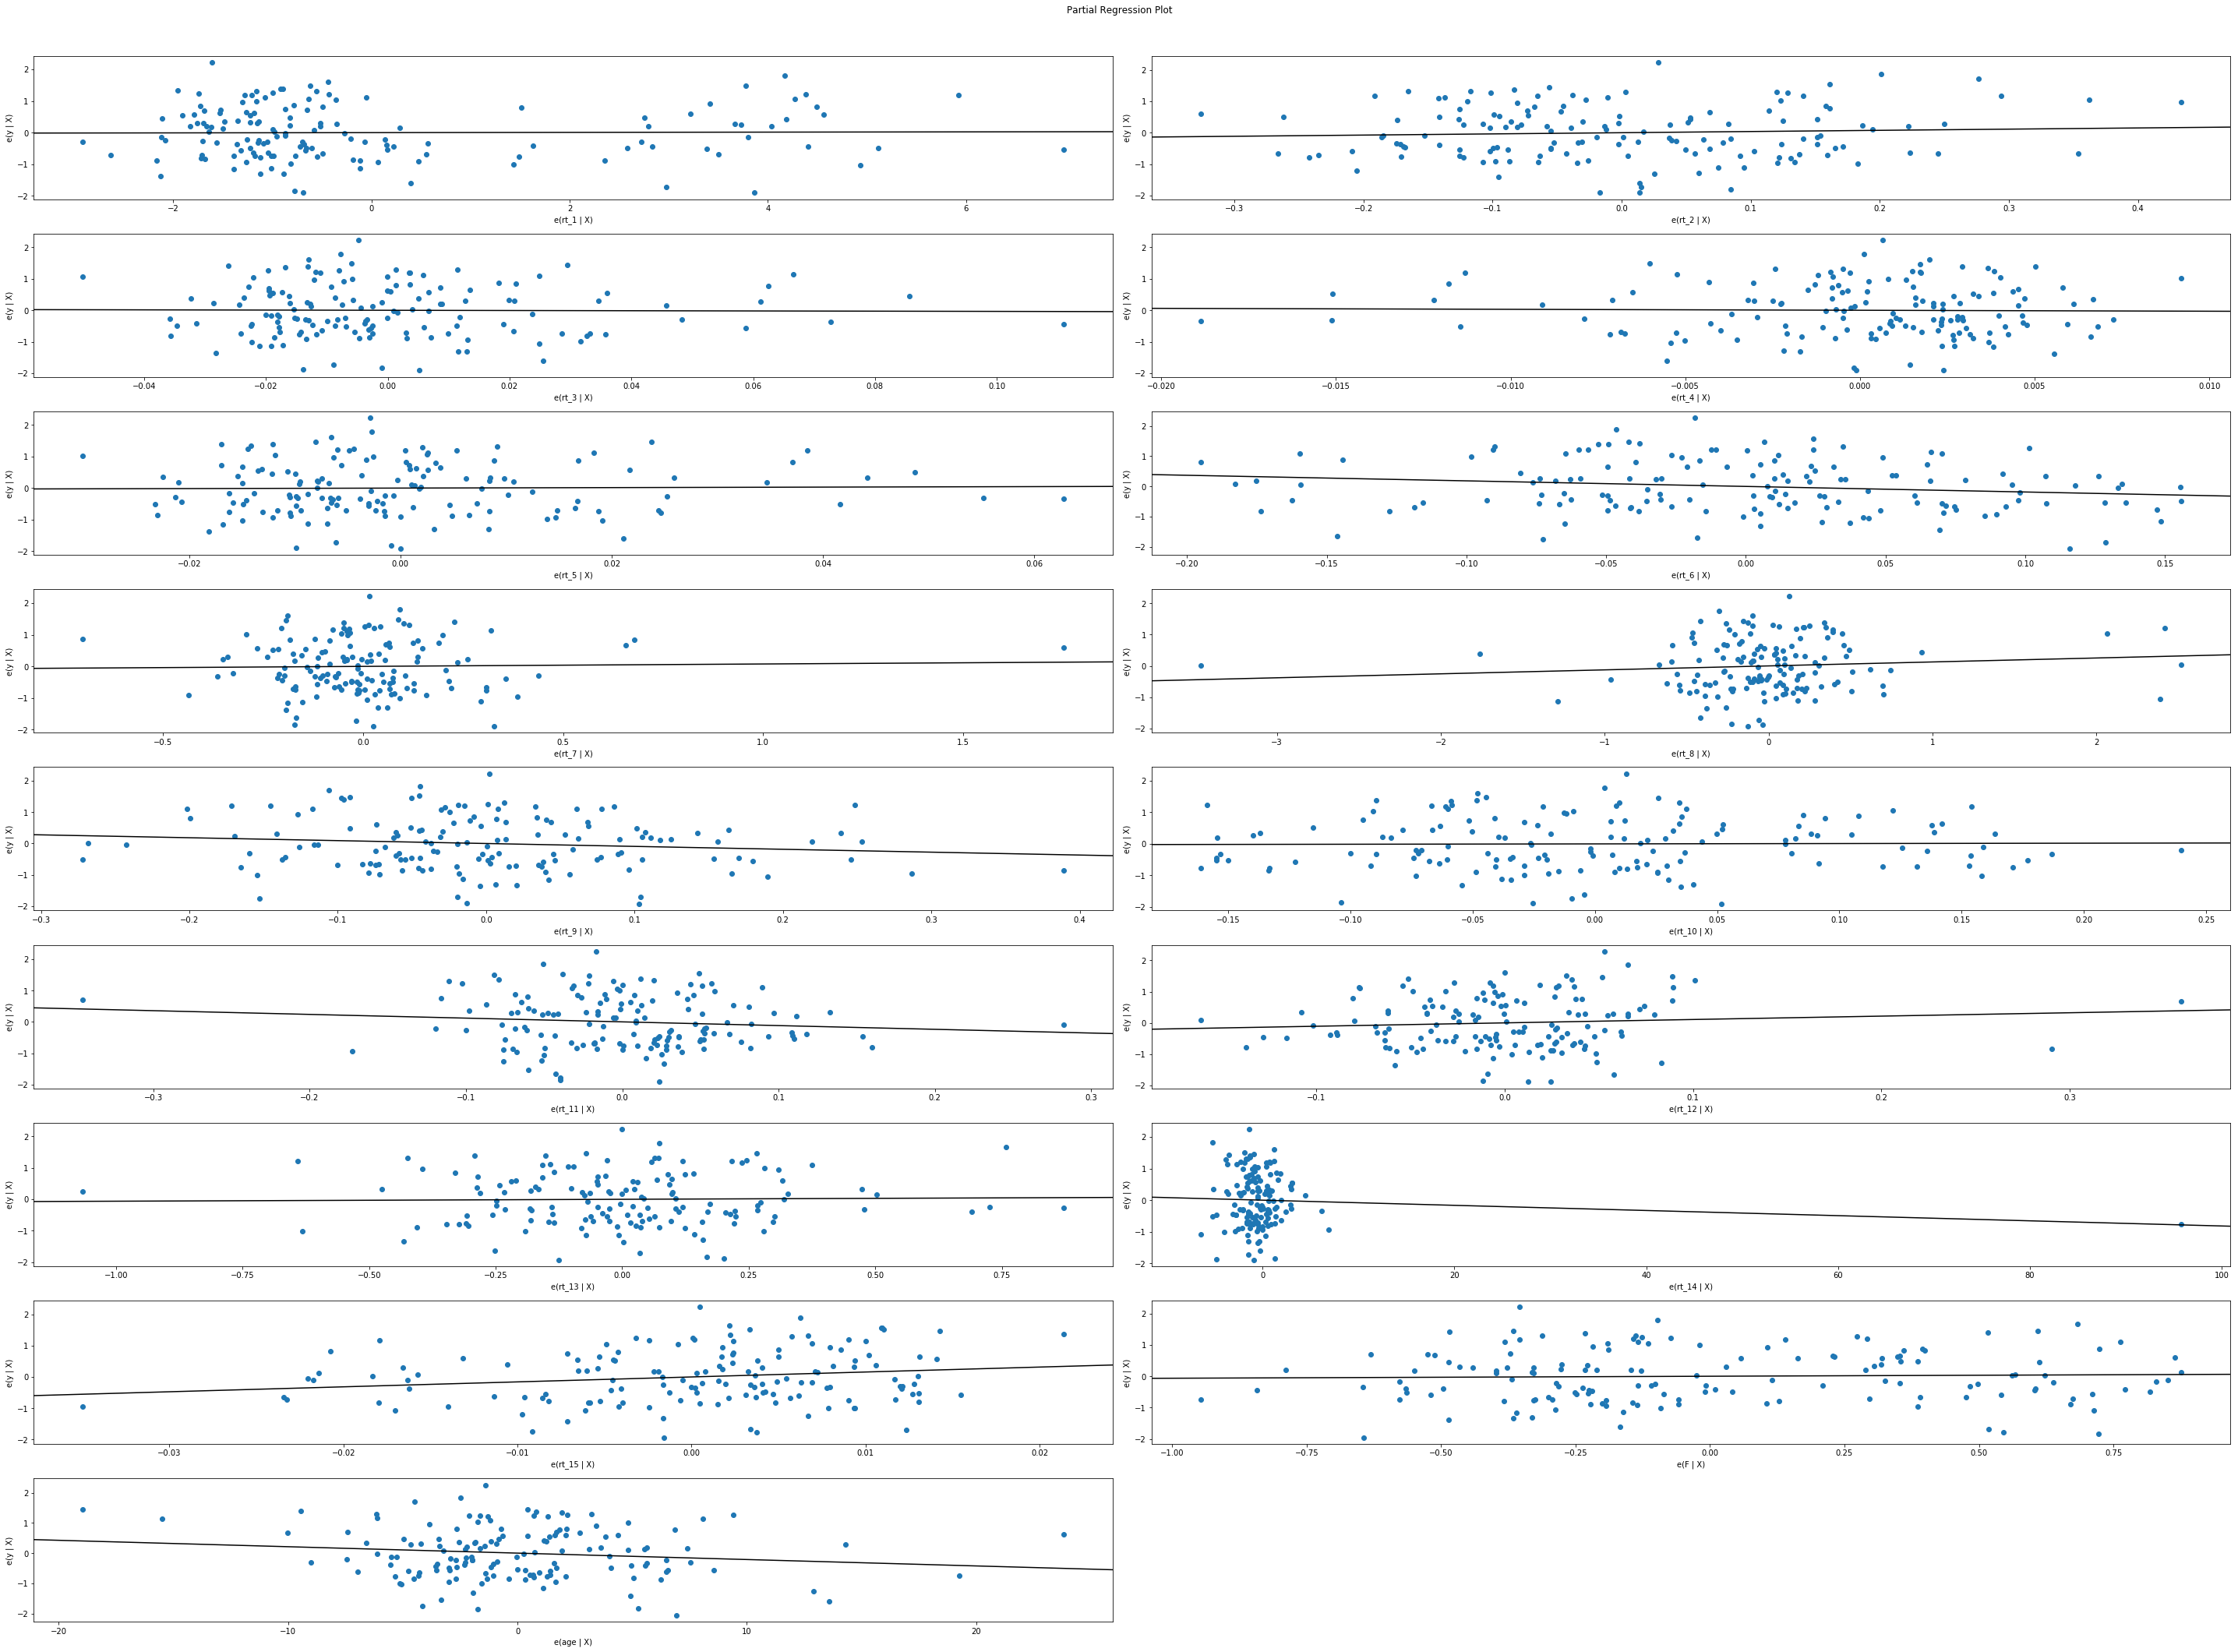

In [85]:
# we fail to reject the null hypothesis and use the full model
fig = plt.figure(figsize=(40,30))
fig = sm.graphics.plot_partregress_grid(lm_full, fig=fig)

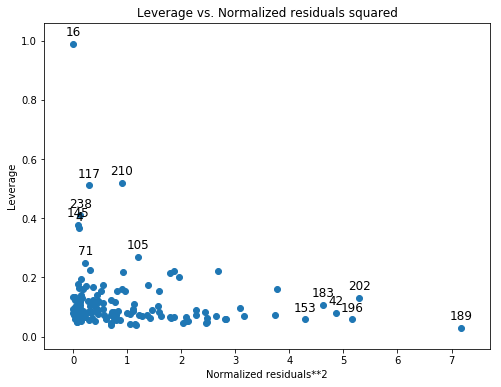

In [86]:
fig, ax = plt.subplots(figsize=(8,6))
fig = sm.graphics.plot_leverage_resid2(lm_full, ax=ax)

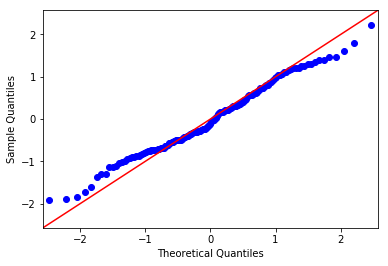

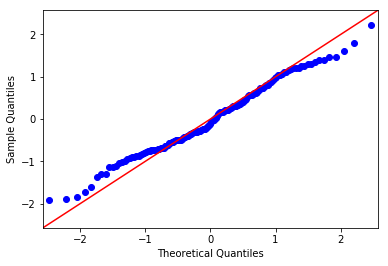

In [95]:
sm.qqplot(lm_full.resid,line='45')

In [106]:
resid = lm_full.resid.as_matrix()

# Create a trace
trace = go.Scatter(
    x = list(range(len(resid))),
    y = resid,
    mode = 'markers'
)

data = [trace]

# Plot and embed in ipython notebook!
py.iplot(data, filename='basic-scatter')